# Прогнозирование количества заказов такси

Имеются исторические данные о заказах такси. Необходимо построить модель для прогнозирования количества заказов такси.

### Содержание:

#### 1) <a href='#Preprocesing'> Изучение и предобработка данных</a>
#### 2) <a href='#Features'> Создание признаков</a>
#### 3) <a href='#Model training'> Обучение модели</a>
#### 4) <a href='#Conclusion'> Вывод</a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

<a id='Preprocesing'></a>
## Изучение и предобработка данных

In [2]:
taxi = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP11\\taxi.csv', index_col='datetime')

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()
display(taxi.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0+ KB


(26496, 1)

Проверяю, что даты идут по порядку:

In [5]:
taxi.index.is_monotonic

True

In [6]:
taxi.index = pd.to_datetime(taxi.index)
type(taxi.index)

pandas.core.indexes.datetimes.DatetimeIndex

Делаю почасовой ресеймплинг:

In [7]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


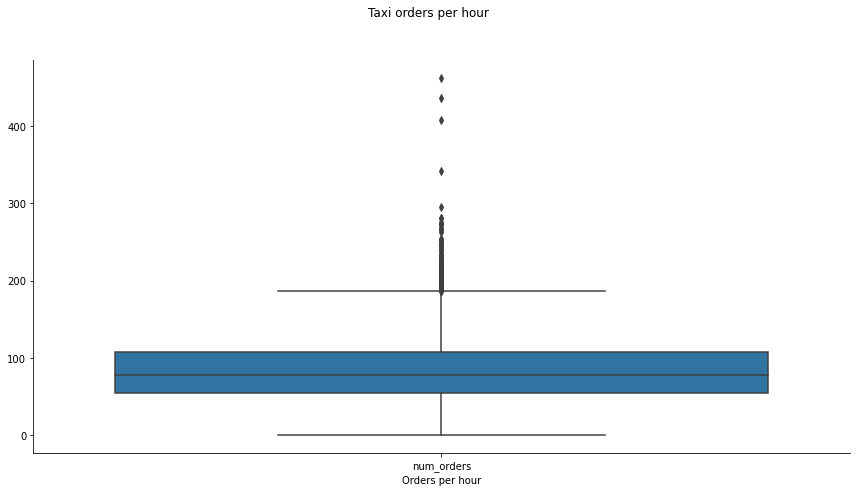

In [8]:
plot = sns.catplot(data=taxi, kind='box', height=6, aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Orders per hour')
plot.set
plot.fig.suptitle('Taxi orders per hour', y=1.1);

Разложим временные ряды на составляющие:

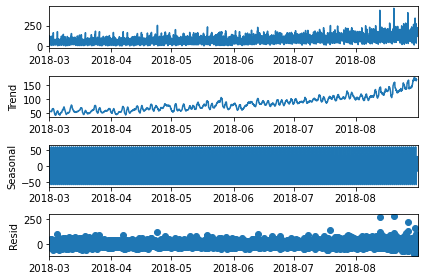

In [9]:
decomposed = seasonal_decompose(taxi)
decomposed.plot();

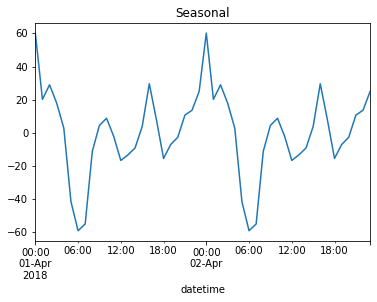

In [10]:
decomposed.seasonal['2018-04-01' : '2018-04-02'].plot(title='Seasonal');

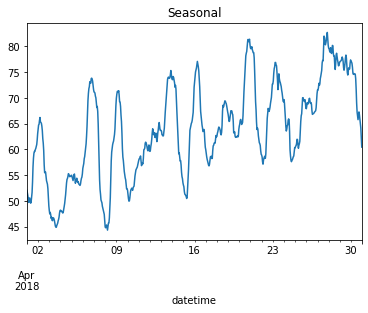

In [11]:
decomposed.trend['2018-04-01' : '2018-04-30'].plot(title='Seasonal');

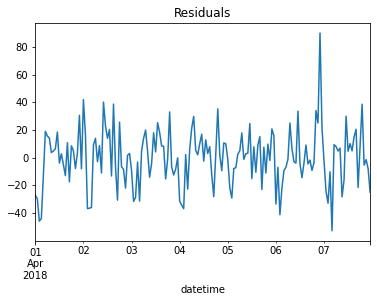

In [12]:
decomposed.resid['2018-04-01' : '2018-04-07'].plot(title='Residuals');

Тренд по кол-ву заказов растущий, предполагаю, что это связано с ростом и развитием самой компании, нежели с сезонностью. Если верить исследованию яндекса (https://yandex.ru/company/researches/2013/ya_moscow_taxi_2013#toc2.1), то сезонности по месяцам у такси нет, только небольшой спад в августе (в связи с отпусками). Сезонность выражена в заказах внутри дня: наименьшее кол-во заказов с 4 до 7 утра, наибольшее кол-во с 23 до 01 ночи.

<a id='Features'></a>
## Создание признаков

Делаю функции для создания новых признаков и применяю их.

In [13]:
def create_calendar_lag_features(data, apply_column : str, lag_range=3):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, lag_range+1):
        data[f'lag_{i}'] = data[apply_column].shift(i)

def create_sma_feature(data, apply_column: str, sma_period):
    data[f'sma_{sma_period}'] = data[apply_column].rolling(window=sma_period).mean()       

In [14]:
create_calendar_lag_features(taxi, 'num_orders', lag_range=5)

In [15]:
create_sma_feature(taxi, 'num_orders', 5)
create_sma_feature(taxi, 'num_orders', 8)
create_sma_feature(taxi, 'num_orders', 13)
create_sma_feature(taxi, 'num_orders', 21)

In [16]:
taxi.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,sma_5,sma_8,sma_13,sma_21
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,77.8,NaN,NaN,NaN


In [17]:
print(taxi.shape)
taxi = taxi.dropna()
print(taxi.shape)

(4416, 12)
(4396, 12)


<a id='Model training'></a>
## Обучение модели

Разбиваю данные:

In [18]:
x_taxi = taxi.drop('num_orders', axis=1)
y_taxi = taxi['num_orders']

In [19]:
x_taxi_train, x_taxi_test, y_taxi_train, y_taxi_test = train_test_split(x_taxi, y_taxi, test_size=0.1 , shuffle=False)
x_taxi_train.shape, x_taxi_test.shape, y_taxi_train.shape, y_taxi_test.shape

((3956, 11), (440, 11), (3956,), (440,))

In [20]:
x_taxi_train.index.is_monotonic, x_taxi_test.index.is_monotonic

(True, True)

In [21]:
regr = lgb.LGBMRegressor()

params = {
    'learning_rate' : [0.1, 0.25, 0.5],
    'n_estimators' : range(200, 1201, 200),
    'objective' : ['root_mean_squared_error']
}

In [22]:
regr_gs = RandomizedSearchCV(regr, params, scoring='neg_mean_squared_error', cv=5, random_state=12345)

In [23]:
regr_gs.fit(x_taxi_train, y_taxi_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(),
                   param_distributions={'learning_rate': [0.1, 0.25, 0.5],
                                        'n_estimators': range(200, 1201, 200),
                                        'objective': ['root_mean_squared_error']},
                   random_state=12345, scoring='neg_mean_squared_error')

In [24]:
regr_best = regr_gs.best_estimator_
regr_best

LGBMRegressor(n_estimators=800, objective='root_mean_squared_error')

In [25]:
train_result = mean_squared_error(y_taxi_train, regr_best.predict(x_taxi_train), squared=False)
test_result = mean_squared_error(y_taxi_test, regr_best.predict(x_taxi_test), squared=False)
print('Train RMSE:', round(train_result,2))
print('Test RMSE:', round(test_result,2))

Train RMSE: 1.02
Test RMSE: 38.09


In [26]:
true_pred = pd.DataFrame({ 
    'y_true' : y_taxi_test,
    'y_pred' : regr_best.predict(x_taxi_test)
    })

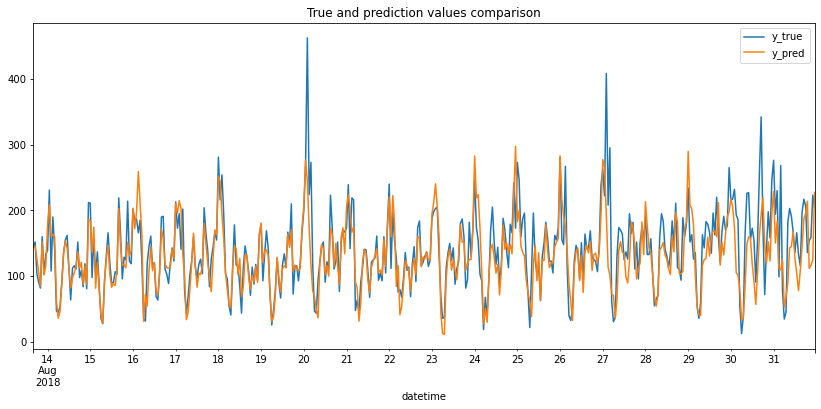

In [27]:
true_pred.plot(figsize=(14,6), title='True and prediction values comparison');

In [28]:
feature_importances = pd.DataFrame({'features' : list(x_taxi_train.columns), 
                                    'feature_importances':  regr_best.feature_importances_})\
                                    .sort_values(by='feature_importances', ascending=False)
print('Влияние признаков на результат предсказания')
display(feature_importances)

Влияние признаков на результат предсказания


,features,feature_importances
7,sma_5,4079
4,lag_3,3294
2,lag_1,2873
5,lag_4,2677
3,lag_2,2529
6,lag_5,1796
8,sma_8,1795
10,sma_21,1657
9,sma_13,1456
1,hour,1154


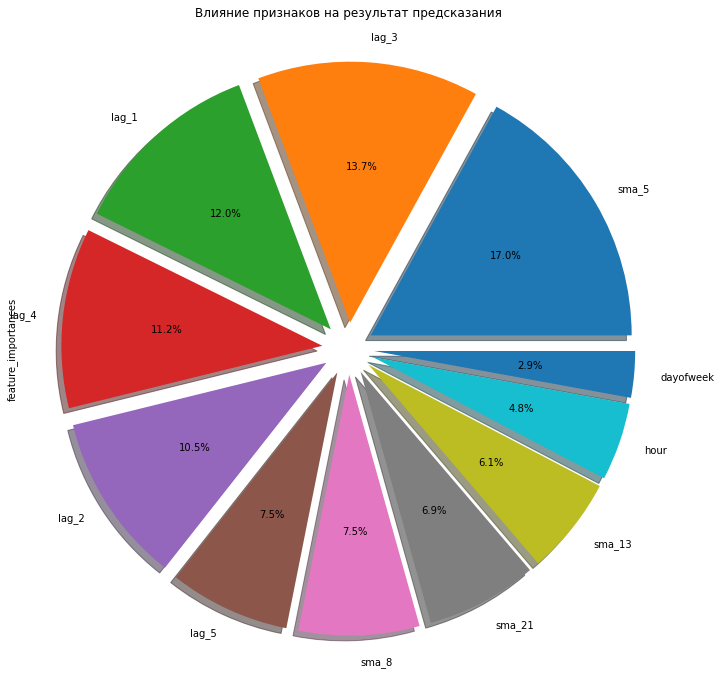

In [29]:
feature_importances.plot.pie(explode=[0.1]*len(x_taxi_train.columns),
                             labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Влияние признаков на результат предсказания');

<a id='Conclusion'></a>
## Вывод

В процессе прогнозирования количества заказов такси было проведено ресемплирование данных, созданы признаки и обучена модель для предсказания количества заказов. Получилось добиться результата RMSE 38.09 на тестовой выборке. Наиболее влияющие на точность предсказания признаки: простая скользящая средняя с периодом 5 (17% от общего веса) и сдвиг с периодом 3 (14% от общего веса).